In [1]:
# %reload_ext autoreload

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


from trampact.preprocess import get_data, drop_tx_columns
from trampact.plot import draw_hist

In [4]:
# Only run once 
%aimport trampact.preprocess
%aimport trampact.plot
%matplotlib inline

In [5]:
!pwd

/home/primitive/code/eangelid/trampact/notebooks


In [6]:
IRIS_T1_CSV = 'iris_T1.csv'
IRIS_T2_CSV = 'iris_T2.csv'
BD_GENT_2006 = 'BD_GENT_2006.csv'
BD_GENT_2016 = 'BD_GENT_2016.csv'

## Load ALL dataframes

#### Load T1 and T2 IRIS codes
Attn: The `get_data()` method automatically sets `iris_id` as the index

In [7]:
iris_T1 = get_data(IRIS_T1_CSV, is_local_csv=True)

In [8]:
iris_T2__full = get_data(IRIS_T2_CSV, is_local_csv=True)

In [9]:
# drop other columns - only keep index (iris_id) and IRIS label (name)
iris_T2 = pd.DataFrame(iris_T2__full['NOM_IRIS'])

#### Load demographic data

In [10]:
bd_gent_2006 = get_data(BD_GENT_2006, is_local_csv=True)

In [11]:
bd_gent_2016 = get_data(BD_GENT_2016, is_local_csv=True)

## Imputing
Do it here before creating new dataframes

#### Take a look at NULL values
Low percentage. We can get away with median (?)

In [12]:
bd_gent_2006.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2006.isnull().sum().sort_values(ascending=False)/len(bd_gent_2006) #NaN percentage for each column

rev_2006                0.048
t_actifs_2006           0.000
tx_voit_2006            0.000
tx_chom_2006            0.000
tx_empl_2006            0.000
tx_ouvr_2006            0.000
tx_TP_2006              0.000
tx_HLM_2006             0.000
tx_no_transp_2006       0.000
tx_walk_2006            0.000
tx_moto_2006            0.000
tx_TC_2006              0.000
HH_2voit_2006           0.000
tx_HH_moins2ans_2006    0.000
tx_HH_2_4ans_2006       0.000
tx_HH_5_9ans_2006       0.000
tx_HH_plus10ans_2006    0.000
tx_HH_with_park_2006    0.000
tx_HH_with_voit_2006    0.000
tx_HH_1voit_2006        0.000
tx_HH_2voit_2006        0.000
pop_2006                0.000
HH_1voit_2006           0.000
t_chom_2006             0.000
walk_2006               0.000
empl_2006               0.000
ouvrier_2006            0.000
TP_2006                 0.000
Int_2006                0.000
app_stage_2006          0.000
cdd_2006                0.000
HLM_2006                0.000
no_transp_2006          0.000
moto_2006 

In [13]:
bd_gent_2016.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2016.isnull().sum().sort_values(ascending=False)/len(bd_gent_2016) #NaN percentage for each column

rev_2016                0.054
tx_empl_prec_2016       0.002
tx_voit_2016            0.002
tx_chom_2016            0.002
tx_empl_2016            0.002
tx_ouvr_2016            0.002
tx_TP_2016              0.002
tx_HLM_2016             0.002
tx_no_transp_2016       0.002
tx_walk_2016            0.002
tx_moto_2016            0.002
tx_TC_2016              0.002
tx_HH_moins2ans_2016    0.002
tx_HH_2_4ans_2016       0.002
tx_HH_5_9ans_2016       0.002
tx_HH_plus10ans_2016    0.002
tx_HH_with_park_2016    0.002
tx_HH_with_voit_2016    0.002
tx_HH_1voit_2016        0.002
tx_HH_2voit_2016        0.002
HH_2voit_2016           0.000
pop_2016                0.000
t_actifs_2016           0.000
t_chom_2016             0.000
walk_2016               0.000
empl_2016               0.000
ouvrier_2016            0.000
TP_2016                 0.000
Int_2016                0.000
app_stage_2016          0.000
CDD_2016                0.000
HLM_2016                0.000
no_transp_2016          0.000
moto_2016 

In [14]:
rev_2006_mean_before = bd_gent_2006['rev_2006'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2006[['rev_2006']])

bd_gent_2006['rev_2006'] = simp_imputer.transform(bd_gent_2006[['rev_2006']])

print(f'rev_2006 - mean: Before {rev_2006_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2006 - mean: Before 17310.4737394958 , After17310.4737394958


In [15]:
rev_2016_mean_before = bd_gent_2016['rev_2016'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2016[['rev_2016']])

bd_gent_2016['rev_2016'] = simp_imputer.transform(bd_gent_2016[['rev_2016']])

print(f'rev_2016 - mean: Before {rev_2016_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2016 - mean: Before 21324.373848523497 , After21324.373848523497


#### Merge datadrames to get T1 quarters ONLY

In [16]:
# bd_gent_2006_T1 = bd_gent_2006.merge(iris_T1, on='iris_id').drop('NOM_IRIS', axis=1)
bd_gent_2006_T1 = bd_gent_2006.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

In [17]:
bd_gent_2016_T1 = bd_gent_2016.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

#### Drop columns with ratios - We do not always need them

In [18]:
bd_gent_2006_no_tx = drop_tx_columns(bd_gent_2006, '2006')

In [19]:
bd_gent_2016_no_tx = drop_tx_columns(bd_gent_2016, '2016')

In [20]:
bd_gent_2006_T1_no_tx = drop_tx_columns(bd_gent_2006_T1, '2006')

In [21]:
bd_gent_2016_T1_no_tx = drop_tx_columns(bd_gent_2016_T1, '2016')

<hr>

<hr>

## Check dataframes
🚨(no need to run this part if not the first time loading the data frames)🚨

In [ ]:
iris_T1.head()

In [ ]:
iris_T2.head()

In [ ]:
bd_gent_2006

In [ ]:
bd_gent_2016

In [ ]:
print(bd_gent_2006.shape)

In [ ]:
print(bd_gent_2016.shape)

In [ ]:
print(bd_gent_2006_T1.shape)

In [ ]:
print(bd_gent_2016_T1.shape)

In [ ]:
print(bd_gent_2006_no_tx.shape)

In [ ]:
print(bd_gent_2016_no_tx.shape)

<hr>

## Draw histograms - compare 2006 to 2016 and Nice vs. T1/T2

In [ ]:
feature_label = 'rev'
draw_hist(bd_gent_2006, bd_gent_2016, bd_gent_2006_T1, bd_gent_2016_T1, feature_label)

## Pearson correlation 🚀

In [ ]:
corr = bd_gent_2006_T1_no_tx.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(15,16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [ ]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.reset_index(inplace=True, drop=True)
corr_df.head()

## Pairplots

In [ ]:
sns.set(style='white')
sns.pairplot(bd_gent_2006_T1_no_tx[['t_chom_2006', 'voit_2006', 'HH_plus_10ans_2006', 'HH_2voit_2006']], height=2)
plt.show()

## Time for a bit of modelling

### Model parameters - Chage these to dig into e.g. Nice or just T1 or 2006 vs 2016


In [103]:
df__X = bd_gent_2016_T1_no_tx

In [104]:
scaler = StandardScaler()
df__X__scaled = pd.DataFrame(scaler.fit_transform(df__X))

In [105]:
pca = PCA()

In [106]:
pca.fit(df__X__scaled)

PCA()

In [107]:
Wt = pd.DataFrame(pca.components_)

In [108]:
df__X__scaled_PCA = pd.DataFrame(pca.transform(df__X__scaled))

<AxesSubplot:>

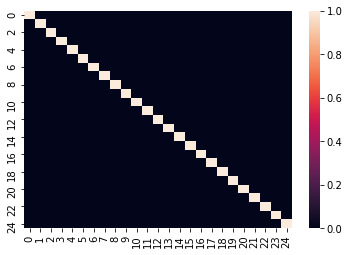

In [109]:
sns.heatmap(df__X__scaled_PCA.corr())

In [110]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy(copy=True) # What was the problem? Wrong datatype expected=numpy, passed:pd.DataFrame

df = pd.DataFrame()
df["vif_index"] = [vif(numpy__X__scaled_PCA, i) for i in range(numpy__X__scaled_PCA.shape[1])]

In [ ]:
df

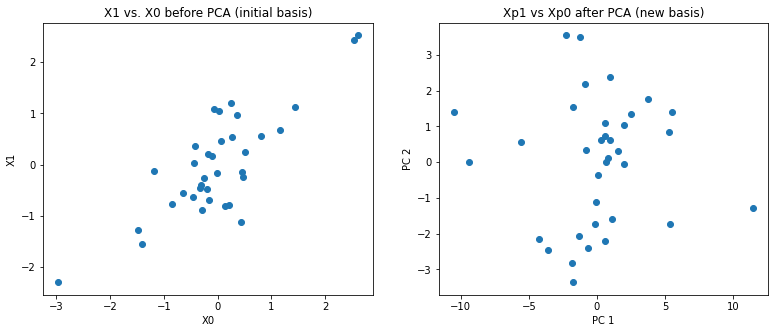

In [111]:
numpy__X__scaled = df__X__scaled.to_numpy()

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial basis)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(numpy__X__scaled[:,0], numpy__X__scaled[:,1])

plt.subplot(1,2,2)
plt.title('Xp1 vs Xp0 after PCA (new basis)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1])

In [112]:
#'Rank' PC per order of 'importance'
df_Xp = df__X__scaled_PCA # sample: pd.DataFrame(Xp)
df_Xp.std()**2 / ((df_Xp.std()**2).sum())

0     6.118290e-01
1     1.231665e-01
2     9.241606e-02
3     4.314697e-02
4     2.767865e-02
5     1.968505e-02
6     1.510761e-02
7     1.435938e-02
8     1.145514e-02
9     7.893472e-03
10    6.735391e-03
11    5.712335e-03
12    4.832761e-03
13    3.766136e-03
14    3.441757e-03
15    2.614336e-03
16    1.895275e-03
17    1.846072e-03
18    1.042644e-03
19    7.123129e-04
20    5.286753e-04
21    1.182457e-04
22    1.622562e-05
23    9.335937e-21
24    3.942431e-22
dtype: float64

In [113]:
pca.explained_variance_ratio_

array([6.11828968e-01, 1.23166529e-01, 9.24160588e-02, 4.31469725e-02,
       2.76786512e-02, 1.96850477e-02, 1.51076108e-02, 1.43593811e-02,
       1.14551422e-02, 7.89347189e-03, 6.73539066e-03, 5.71233474e-03,
       4.83276085e-03, 3.76613582e-03, 3.44175683e-03, 2.61433648e-03,
       1.89527540e-03, 1.84607203e-03, 1.04264415e-03, 7.12312948e-04,
       5.28675338e-04, 1.18245677e-04, 1.62256175e-05, 9.33593830e-21,
       3.94243100e-22])

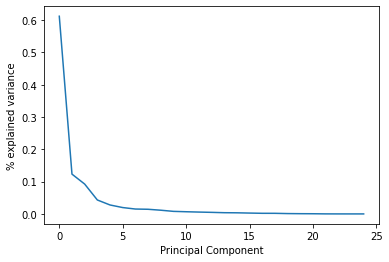

In [114]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

In [115]:
eig_vals, eig_vecs = np.linalg.eig(np.dot(df__X__scaled.T,df__X__scaled))

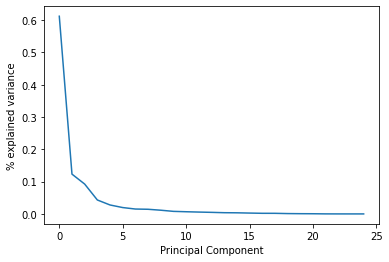

In [116]:
# Compute the share of explained variance per component
tot = sum(eig_vals)
share_of_variances = [(i / tot) for i in sorted(eig_vals, reverse=True)]
plt.plot(share_of_variances); 
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

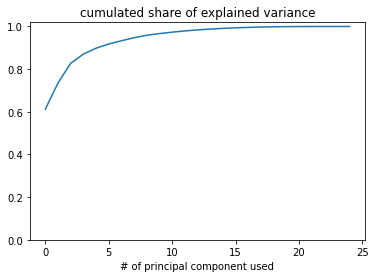

In [117]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [118]:
y_pred = df__X__scaled[24]

# model = LogisticRegression()
from sklearn.linear_model import LinearRegression
model = LinearRegression()

print("accuracy all features")
cross_val_score(model, df__X__scaled, y_pred, cv=10).mean()

accuracy all features


1.0

In [119]:
#
# !--- HERE!!!! Type the number of components that PCA found or you want to use ---!
#
n_components = 3

In [120]:
pca2 = PCA(n_components).fit(df__X__scaled)

# Print our 2 principal components
pd.DataFrame(pca2.components_)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.253516,-0.206822,-0.225786,-0.199420,-0.224335,-0.121001,-0.128208,-0.222214,0.023998,-0.098817,...,-0.248365,-0.158741,-0.220983,-0.226071,-0.224875,-0.206945,-0.237944,-0.241126,-0.183197,-0.251963
1,0.033111,0.046574,-0.160604,-0.194297,0.148485,-0.115560,0.284281,0.144704,0.127090,-0.346425,...,0.085128,0.320814,0.158061,0.054709,-0.103775,-0.229938,-0.102114,-0.063127,-0.222351,-0.015486
2,0.007178,-0.252491,-0.087497,-0.277749,-0.049358,-0.389215,0.025191,-0.024052,0.593390,-0.218613,...,0.005094,-0.116869,-0.051525,0.007356,0.101526,0.204908,0.200608,0.173085,0.262041,-0.039069


In [121]:
X__pca__2 = pca2.fit_transform(df__X__scaled)

In [90]:
pd.DataFrame(X__pca__2)

,0,1,2
0,-6.758376,-0.134601,0.090196
1,-6.833703,-0.087770,0.193325
2,-5.101420,0.318347,0.744032
3,-2.602087,0.067142,0.177118
4,0.456624,-1.843673,0.494858
...,...,...,...
495,4.107194,-0.702343,-0.097405
496,3.342883,-3.693500,-0.520293
497,1.640294,-1.730081,-0.118339
498,-4.928702,-0.305038,-0.412369


In [122]:
print(f"accuracy {n_components} features")
cross_val_score(model, X__pca__2, y_pred, cv=10).mean()

accuracy 3 features


0.2918268456568541

In [123]:
# Keep only 1 dimension
pca1 = PCA(n_components=1)

X__pca__1 = pca1.fit_transform(df__X__scaled) # Reminder: df__X_scaled == bd_gent_20??_no_tx__scaled

pd.DataFrame(X__pca__1)
print("accuracy 1 features")
cross_val_score(model, X__pca__1, y_pred, cv=10).mean()

accuracy 1 features


0.18632587422131563

# KMeans

In [124]:
#
# !--- HERE!!!! Type the number of components you want to use ---!
#
# n_clusters = 3
n_clusters = n_components

In [125]:
km = KMeans(n_clusters)
km.fit(df__X__scaled_PCA)

KMeans(n_clusters=3)

In [96]:
km.cluster_centers_

array([[ 4.44250796e-01,  1.48552630e-01, -2.44237648e-01,
        -5.57177873e-02, -9.62454720e-02,  7.69229388e-03,
         1.36236893e-01, -6.50103601e-02, -3.33768744e-02,
         5.95151663e-02, -1.52093478e-02, -3.73539209e-02,
         2.26033632e-02, -1.36316526e-02, -2.94855383e-02,
        -1.24010695e-02,  1.25396773e-03, -1.45372517e-02,
         1.18121569e-02,  3.01692774e-04,  6.42474875e-03,
        -9.40398840e-03,  1.67643419e-04, -1.96523542e-12,
         6.60968799e-13],
       [-5.26769086e+00, -8.47248384e-02,  2.33453769e-01,
         4.80777642e-02,  8.93150529e-02,  1.83553867e-03,
        -1.30114528e-01,  8.26590357e-02,  5.36021348e-02,
        -7.56881086e-02,  6.03947589e-03,  7.19225113e-02,
        -2.35542542e-02,  1.95344997e-02,  2.09985017e-02,
        -7.59638348e-03,  3.80413632e-03,  2.38903569e-02,
        -3.42319988e-03, -4.34335473e-04, -7.98906327e-03,
         1.06708690e-02,  2.15743648e-04,  1.18230834e-11,
         6.76707537e-12],
    

In [97]:
km.labels_

array([1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2,
       0, 1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 0, 2, 0, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 2, 2, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Text(0, 0.5, 'PC 2')

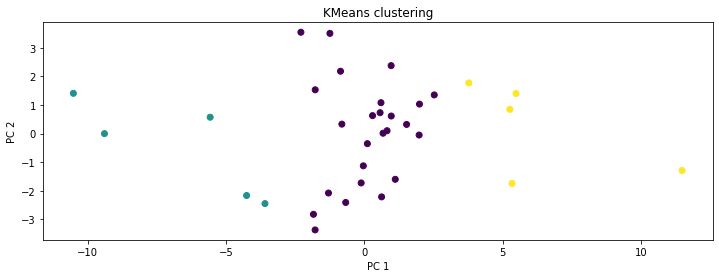

In [126]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy()

plt.figure(figsize=(12,4))
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering'); 
plt.xlabel('PC 1');
plt.ylabel('PC 2')

Text(0.5, 1.0, 'True classification')

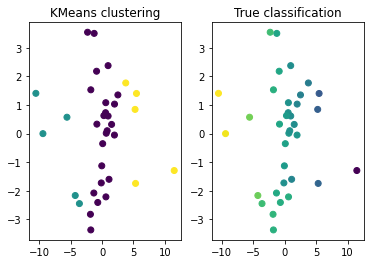

In [127]:
plt.subplot(1,2,1)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering')

plt.subplot(1,2,2)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=y_pred)
plt.title('True classification')

In [100]:
# ?????
km.predict(new_X)

NameError: name 'new_X' is not defined

Text(0.5, 0, 'k cluster number')

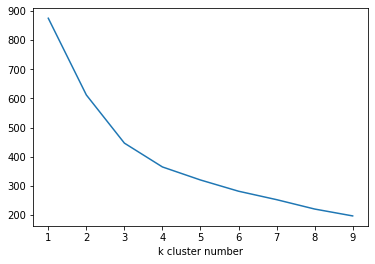

In [128]:
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(df__X__scaled_PCA)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')